In [1]:
import os
import numpy as np
from numpy import exp
import time
import sys
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def show_slices(slices,clims=[0.0,0.0]):
    fig, axes = plt.subplots(1,len(slices))
    for i, slice in enumerate(slices):
        if clims==[0.0,0.0]:
            axes[i].imshow(slice.T, cmap='gray', origin="lower")
        else:
            axes[i].imshow(slice.T, cmap='gray', origin="lower", clim=clims)
def size(A):
    sizei = 1
    for dim in np.shape(A): sizei = sizei*dim
    return sizei

## T1 fit functions
# TR is a global variable here...
def myT1fit2(t,T1,M0):
    fit =  M0 * (1 - 2*exp(-t/T1) + exp(- TR/T1));
    # e = (data(:) - fit(:))**2;
    return fit

def fitT12(sortTIi,modSlice,maskSlice2):
    datasize=int(modSlice.shape[0])
    t1=np.zeros((datasize,1))
    m0=np.zeros((datasize,1))
    r2=np.zeros((datasize,1))
    e2=np.zeros((datasize,1))
    #modSlice already flattened as input...
    for i in range(0,datasize):#range(int(datasize/2-1000),int(datasize/2+1000)):#
        if maskSlice2[i]:
            modSlicei=modSlice[i,:]
            params,pcov=curve_fit(myT1fit2,sortTIi,modSlicei,p0=[1000,modSlicei[-1]],
                                  bounds=[[0,0],[10000,1e7]],maxfev=500,ftol=0.01,xtol=0.01)
            t1[i]=params[0]
            m0[i]=params[1]
            r2[i]=sum((myT1fit2(sortTIi,params[0],params[1])-modSlicei)**2)
            e2[i]=np.sqrt(np.diag(pcov))[0]
        else:
            t1[i]=0
            m0[i]=0
            r2[i]=0
            e2[i]=0
    return t1,m0,r2,e2

def myT1fit3(t,T1,M0,alpha):
    fit =  M0 * (1 - alpha*exp(-t/T1) + exp(- TR/T1));
    #fit = M0 +alpha*exp(-t/T1)
    return fit

def fitT13(sortTIi,modSlice,maskSlice2):
    datasize=int(modSlice.shape[0])
    t1=np.zeros((datasize,1))
    m0=np.zeros((datasize,1))
    alpha=np.zeros((datasize,1))
    r2=np.zeros((datasize,1))
    e2=np.zeros((datasize,1))
    #modSlice already flattened as input...
    for i in range(0,datasize):#range(int(datasize/2-1000),int(datasize/2+1000)):#
        if maskSlice2[i]:
            modSlicei=modSlice[i,:]
            params,pcov=curve_fit(myT1fit3,sortTIi,modSlicei,p0=[1500,modSlicei[-1],1.9],
                                  bounds=[[0,0,1.5],[10000,1e10,2]],maxfev=1000,ftol=0.01,xtol=0.01)
            t1[i]=params[0]
            m0[i]=params[1]
            alpha[i]=params[2]
            r2[i]=sum((myT1fit3(sortTIi,params[0],params[1],params[2])-modSlicei)**2)
            e2[i]=np.sqrt(np.diag(pcov))[0]
        else:
            t1[i]=0
            m0[i]=0
            alpha[i]=0
            r2[i]=0
            e2[i]=0
    return t1,m0,alpha,r2,e2

In [2]:
in_dir = os.path.join(os.getcwd(),'MP2RAGEs')
out_dir = os.path.join(os.getcwd(),'MP2RAGEs')
show_data=True

# Input parameters
sub_ID='T1_sliceOrder_WIP_MSEPI-SPIR-ascend_SENSE_7_1'
nTIs=5;
MBfactor=1
TR=3200
sliceOffsets=[0,13,26,39,52]
minTI=44.5


# Load input data
sub_dir=in_dir+'/'+sub_ID
imgm=nib.load(sub_dir+'_modulus.hdr')
imgm_img = imgm.get_fdata()
imgp=nib.load(sub_dir+'_phase.hdr')
imgp_img = imgp.get_fdata()

imgm_header=imgm.header
dimensions=imgm_header['dim']
nX=dimensions[1]
nY=dimensions[2]
nS=dimensions[3]
nTIs=dimensions[4]
nS_MB1=nS/MBfactor; #number of slices per band
Tseg=TR/nS_MB1;

#TIs=(0:1:(nS_MB1-1))*Tseg+ones(1,nS_MB1)*44.5; 
TIs = minTI + Tseg*np.arange(0,nS_MB1,1,dtype=float)

#TIs=repmat(TIs,[1 MBfactor]);
TIs=np.tile(TIs,(1,MBfactor))

# Default ascend order goes from 1 to nS
default=np.arange(1,nS_MB1+1,1)

ascend=np.zeros((len(sliceOffsets),nS))
print(nS)
for sJump in range(0,len(sliceOffsets)):
    ascend[0:nS-1][sJump]=np.roll(default,-sliceOffsets[sJump])

if MBfactor>1:
    for sJump in range(0,len(sliceOffsets)):
        ascend[0][sJump]=np.tile(ascend[0][sJump], (1,MBfactor));
        for iBand in range(1,MBfactor-1):
            firstslice=nS_MB1*(iBand-1)+1
            subslices=np.arange(firstslice,nS_MB1*iBand)
            ascend[subslices][sJump]=ascend[subslices][sJump]+nS_MB1*(iBand-1);

print(ascend[0])
print(nS)
print(nTIs)

65
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.]
65
5


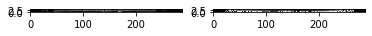

In [3]:
sortTI=np.zeros((len(sliceOffsets),nS))
sortTIindex=np.zeros((len(sliceOffsets),nS),dtype=int)
sortTI2=np.zeros((len(sliceOffsets),nS))

modData=np.zeros((nX,nY,nS,nTIs))
phData=np.zeros((nX,nY,nS,nTIs))

TI_slice=np.zeros((len(sliceOffsets),nS))
for iSlice in range(0,nS): 
    for sJump in range (0,len(sliceOffsets)):
        #put into TI_slice the actual TI based on TIs array
        a=[int(y-1) for y in ascend[sJump]] 
        if iSlice in a:
            TI_slice[sJump][iSlice]=TIs[0][a.index(iSlice)]

sortTI=np.sort(TI_slice,axis=0)
sortTIindex=np.argsort(TI_slice,axis=0)

#for iSlice in range (0,nS):
#    sortTI2[:,iSlice]=TI_slice[sortTIindex[:,iSlice],iSlice]
#print(sortTI2-sortTI)

for iSlice in range(0,nS): 
    #Need to sort data so that TIs etc are in increasing order
    index=sortTIindex[:,iSlice]
    modData[:,:,iSlice,:]=imgm_img[:,:,iSlice,index]; 
    phData[:,:,iSlice,:]=imgp_img[:,:,iSlice,index]; 

if show_data:
    show_slices([modData[:,100,10,:],phData[:,100,10,:]])
    

In [4]:
Rearranged_img = nib.nifti1.Nifti1Image(modData, None, header=imgm.header)
Rearranged_img.to_filename(sub_dir+'_modulus_rearranged.nii.gz')
Rearranged_phs = nib.nifti1.Nifti1Image(phData, None, header=imgp.header)
Rearranged_phs.to_filename(sub_dir+'_phase_rearranged.nii.gz')
#maskDatab=np.zeros((nX,nY,nS),dtype=bool)
maskDatai=np.zeros((nX,nY,nS),dtype=int)

maskData=(np.sum(modData,axis=3)>10)
maskDatai=maskData.astype(int)
    
print(imgm.header.get_data_shape())
mask = nib.nifti1.Nifti1Image(maskDatai, imgm.affine)
mask.to_filename(sub_dir+'_mask.nii.gz')    

#load mask generated by bet instead:
# command1: fslmaths T1_16_1_modulus -Tmean T1_16_1_avg
# command2: bet T1_16_1_avg.nii.gz T1_16_1_mask -m -Z -f 0.2
imgm=nib.load(sub_dir+'_mask_mask.nii.gz')
maskData = imgm.get_fdata()
maskDatai=maskData.astype(int)

(288, 288, 65, 5)


In [5]:
# T1 fit routine:
T1fit=np.zeros((nX,nY,nS))
M0fit=np.zeros((nX,nY,nS))
alphafit=np.zeros((nX,nY,nS))
r2fit=np.zeros((nX,nY,nS))
e2fit=np.zeros((nX,nY,nS))
modSlice=np.zeros((nX,nY,nS))

#print(type(nX))
sisl=int(nX)*int(nY)*int(nTIs)
nXY=int(nX)*int(nY)
phSlice=np.zeros((nX,nY,nTIs))#float64 by default
phDiff0=np.zeros((sisl,1))
phDiff=np.zeros((nX,nY,nTIs))
phDiff2=np.zeros((nXY,nTIs))
indices=np.zeros((nXY,nTIs),dtype=bool)
modSlice=np.zeros((nX,nY,nS))
modSlice2=np.zeros((int(nX)*int(nY),nS))

show_data=False

for iSlice in range(0,nS):#nS
    start_time = time.time()
#     if maskDatab[:,:,iSlice]:  
    print('Computing slice '+str(iSlice))
    modSlice= modData[:,:,iSlice,:]
    phSlice = phData[:,:,iSlice,:]
    maskSlice = maskDatai[:,:,iSlice]
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #Perform correction of modulus polarity based on phase 
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # get phase reference
    phRef = phSlice[:,:,-1]
    
    phDiff = np.repeat(phRef,nTIs,axis=1).reshape(nX,nY,nTIs) - phSlice;
    # add 2*pi to locations where PH < 0
    phDiff0=phDiff.ravel()
    aa=phDiff0<0
    phDiff0[aa]=phDiff0[aa]+2*np.pi
    
    phDiff2 = phDiff0.reshape(nXY,nTIs)
    
    if show_data:
        show_slices([phDiff[:,:,0],phDiff[:,:,1]])
        
    modSlice2 = np.reshape(modSlice,(nXY,nTIs))
    maskSlice2 = np.reshape(maskSlice,(nXY,1))
    
    for ipix in range(0,nXY):
        i_jump=nTIs-1
        while i_jump >= 0: #range(nTIs-1,0,-1):
            indices[ipix,i_jump] = np.equal(np.greater(phDiff2[ipix,i_jump],np.pi/2), \
                                            np.less(phDiff2[ipix,i_jump],3*np.pi/2))
            if indices[ipix,i_jump]:
                for i_jumpi in range(0,i_jump+1):
                    modSlice2[ipix,i_jumpi] = -modSlice2[ipix,i_jumpi]
                    indices[ipix,i_jumpi]=True
                break
            else:
                i_jump=i_jump-1
    
    if show_data:
        # Polarity corrected
        modSlice = np.reshape(modSlice2,(nX,nY,1,nTIs))
        show_slices([modSlice[:,:,0,0],modSlice[:,:,0,1]])
        show_slices([modSlice[:,:,0,2],modSlice[:,:,0,3]])
    
    #Perform fit and save result for this slice?!?
    t1,m0,r2,e2=fitT12(sortTI[:,iSlice],modSlice2,maskSlice2)
    #t1,m0,alpha,r2,e2=fitT13(sortTI[:,iSlice],modSlice2,maskSlice2)

     
    #save results in 3D array
    T1fit[:,:,iSlice]=np.reshape(t1,(nX,nY))
    M0fit[:,:,iSlice]=np.reshape(m0,(nX,nY))
    #alphafit[:,:,iSlice]=np.reshape(alpha,(nX,nY))
    r2fit[:,:,iSlice]=np.reshape(r2,(nX,nY))
    e2fit[:,:,iSlice]=np.reshape(e2,(nX,nY))
    print("--- %s seconds ---" % (time.time() - start_time))
  
# save out data
t1img=nib.nifti1.Nifti1Image(T1fit, imgm.affine)
t1img.to_filename(sub_dir+'_T1.nii.gz')  
m0img=nib.nifti1.Nifti1Image(M0fit, imgm.affine)
m0img.to_filename(sub_dir+'_M0.nii.gz')  
#alphaimg=nib.nifti1.Nifti1Image(alphafit, imgm.affine)
#alphaimg.to_filename(sub_dir+'_alpha.nii.gz')  
r2img=nib.nifti1.Nifti1Image(r2fit, imgm.affine)
r2img.to_filename(sub_dir+'_R2.nii.gz')  
e2img=nib.nifti1.Nifti1Image(e2fit, imgm.affine)
e2img.to_filename(sub_dir+'_E2.nii.gz')  


Computing slice 0
--- 88.95017290115356 seconds ---
Computing slice 1
--- 87.97348070144653 seconds ---
Computing slice 2
--- 87.81272554397583 seconds ---
Computing slice 3
--- 87.62235951423645 seconds ---
Computing slice 4
--- 87.22955250740051 seconds ---
Computing slice 5
--- 87.27049851417542 seconds ---
Computing slice 6
--- 87.63687205314636 seconds ---
Computing slice 7
--- 87.91848182678223 seconds ---
Computing slice 8
--- 87.6820113658905 seconds ---
Computing slice 9
--- 88.41989636421204 seconds ---
Computing slice 10
--- 89.2937879562378 seconds ---
Computing slice 11
--- 88.99841380119324 seconds ---
Computing slice 12
--- 88.92632007598877 seconds ---
Computing slice 13
--- 86.77200722694397 seconds ---
Computing slice 14
--- 84.75200843811035 seconds ---
Computing slice 15
--- 83.27108550071716 seconds ---
Computing slice 16
--- 82.48020648956299 seconds ---
Computing slice 17
--- 84.12927341461182 seconds ---
Computing slice 18
--- 83.11576581001282 seconds ---
Compu

In [1]:
if show_data:
    t1s = np.reshape(t1,(nX,nY))
    m0s = np.reshape(m0,(nX,nY))
    r2s = np.reshape(r2,(nX,nY))
    #phDiff = np.reshape(phDiff2,(nX,nY,1,nTIs)) 
    show_slices([t1s,m0s])
    show_slices([r2s,t1s])

    T1fit[:,:,iSlice]=np.reshape(t1,(nX,nY))
    M0fit[:,:,iSlice]=np.reshape(m0,(nX,nY))
    r2fit[:,:,iSlice]=np.reshape(r2,(nX,nY))



NameError: name 'show_data' is not defined